# NYC Taxi data using dask_cudf

## Import cuxfilter

In [ ]:
from cuxfilter import charts
import cuxfilter
from bokeh import palettes
from cuxfilter.layouts import double_feature

import cudf, dask_cudf

from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

cluster = LocalCUDACluster()
client = Client(cluster)
client

In [ ]:
#update data_dir if you have downloaded datasets elsewhere
DATA_DIR = './data'

## Download required datasets

In [ ]:
from cuxfilter.sampledata import datasets_check
datasets_check('nyc_taxi', base_dir=DATA_DIR)

## preprocess the data

In [ ]:
cudf_df = cudf.read_csv('./data/nyc_taxi.csv', npartitions=2)

from pyproj import Proj, transform

inProj = Proj(init='epsg:4326') # Latitude and longitudes
outProj = Proj(init='epsg:3857') # 2D projected points

cudf_df['dropoff_x'], cudf_df['dropoff_y'] = transform(inProj, outProj, cudf_df['dropoff_longitude'].to_array(), cudf_df['dropoff_latitude'].to_array()) # Apply transformation

cudf_df = cudf_df.drop(['dropoff_latitude', 'dropoff_longitude'], axis=1)
cudf_df = cudf_df.dropna(axis=0)


cudf_df = cudf_df[(cudf_df.dropoff_x > -8239910.23) & (cudf_df.dropoff_x < -8229529.24) & (cudf_df.dropoff_y > 4968481.34) & (cudf_df.dropoff_y < 4983152.92)] # Filter over Manhattan


cudf_df.head()

## Convert cudf df to dask_cudf df

In [ ]:
cudf_df = dask_cudf.from_cudf(cudf_df, npartitions=2).persist()

## Read the dataset

In [6]:
cux_df = cuxfilter.DataFrame.from_dataframe(cudf_df)

## Define charts

In [7]:
from bokeh.tile_providers import get_provider as gp
tile_provider = gp('CARTODBPOSITRON')

Uncomment the below lines and replace MAPBOX_TOKEN with mapbox token string if you want to use mapbox map-tiles. Can be created for free here -https://www.mapbox.com/help/define-access-token/

In [8]:
#from cuxfilter.assets.custom_tiles import get_provider, Vendors
#tile_provider = get_provider(Vendors.MAPBOX_LIGHT, access_token=MAPBOX_TOKEN)

In [9]:
chart1 = charts.scatter(x='dropoff_x',
                         y='dropoff_y',
                         aggregate_fn='mean',aggregate_col='payment_type', pixel_shade_type='log', legend_position='center',
                         tile_provider=tile_provider, x_range=(-8239910.23,-8229529.24), y_range=(4968481.34,4983152.92))

chart2 = charts.bar('passenger_count', data_points=9)

## Create a dashboard object

In [10]:
d = cux_df.dashboard([chart1, chart2], layout=double_feature, theme=cuxfilter.themes.rapids, title= 'NYC TAXI DATASET')

In [11]:
#dashboard object
d

#### cuxfilter DashBoard
    
    [title] (Markdown(str), [])
    [chart1] (Column(sizing_mode='scale_both', width=900)
    [0] Bokeh(Figure), [])
    [chart2] (Column(sizing_mode='scale_both', width=900)
    [0] Bokeh(Figure)
    [1] RangeSlider(end=9, sizing_mode='scale_width', step=1, value=(0, 9), width=900), [])
    [widgets] (Column
    [0] Column(css_classes=['non-handle-temp'], sizing_mode='scale_both')
        [0] FloatSlider(bar_color='#5742f5', end=11075631, name='Data Points selected', sizing_mode='scale_both', value=11075631, width=280), [])

## Starting the dashboard

1. d.show('current_notebook_url:current_notebook_port') remote dashboard

2. d.app('current_notebook_url:current_notebook_port') inline in notebook (layout is ignored, and charts are displayed one below another)

Incase you need to stop the server:

- d.stop()

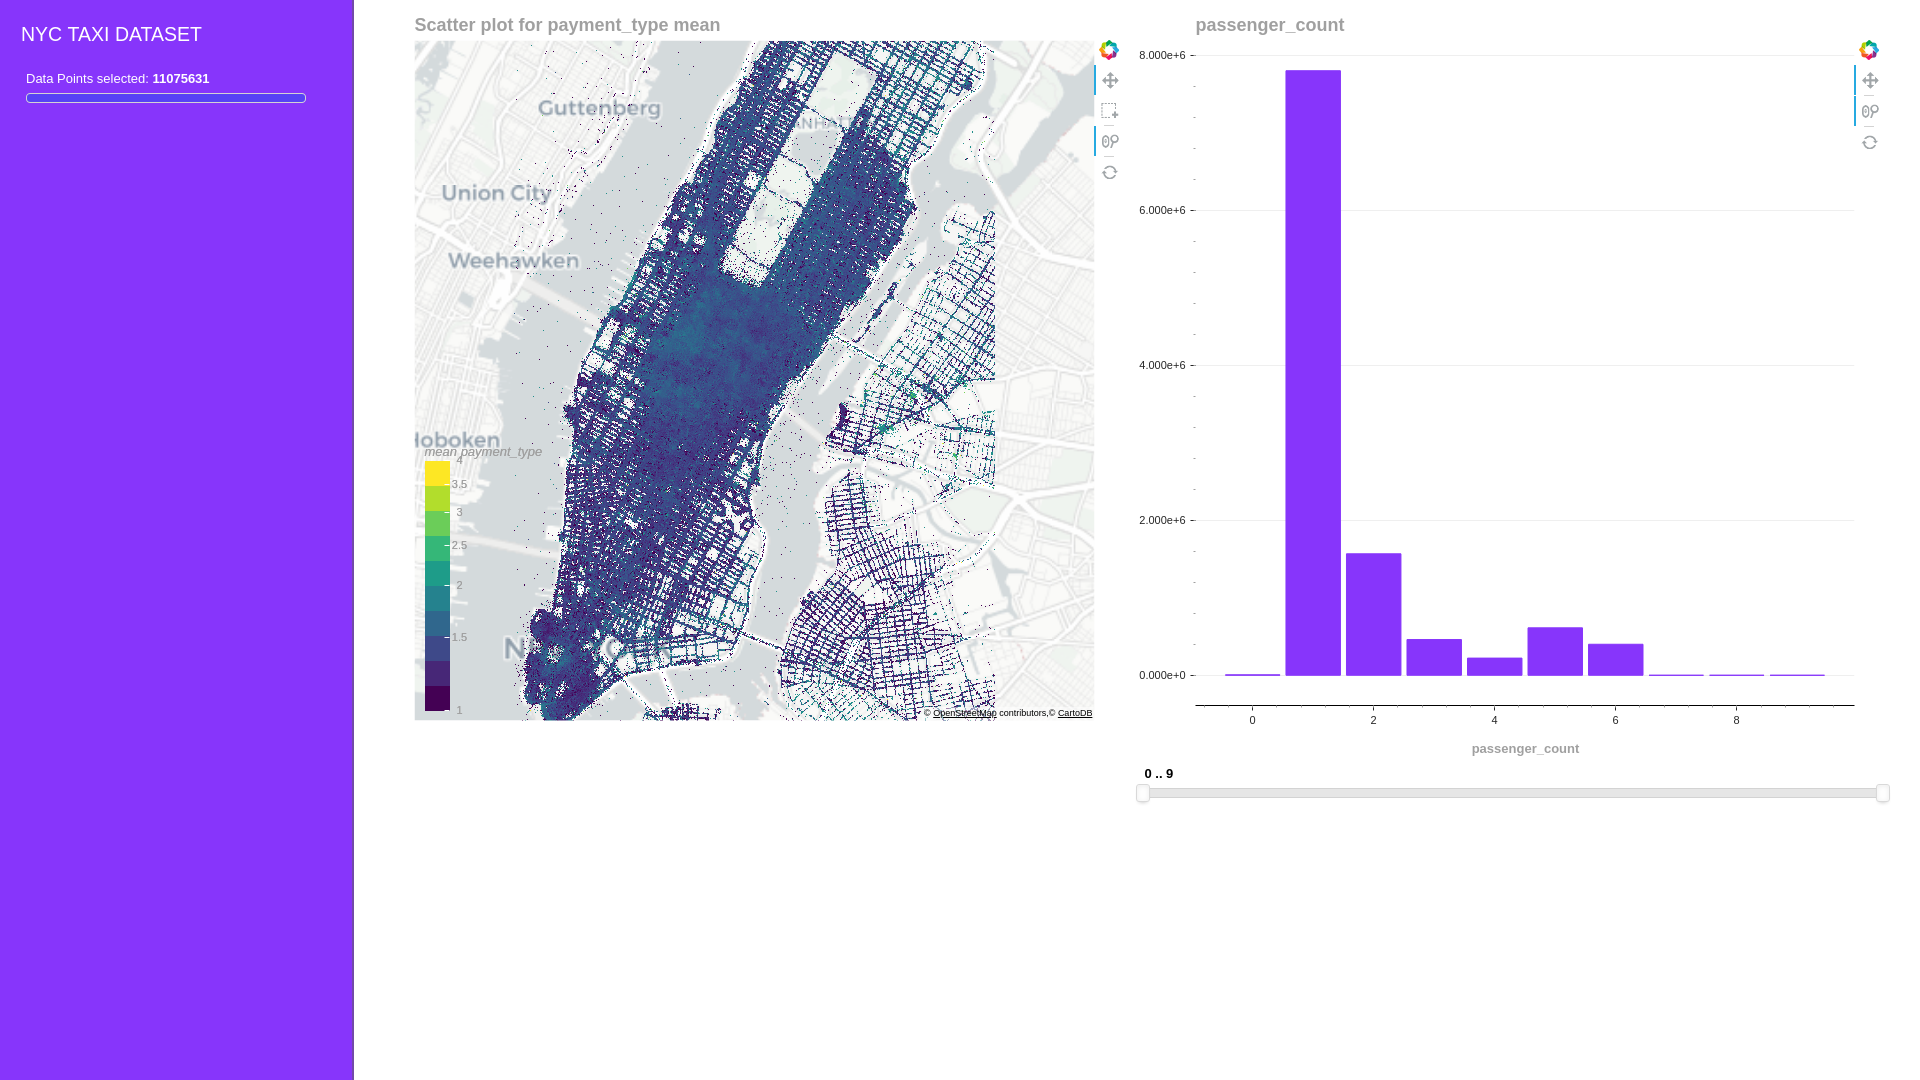

In [12]:
# preview 
await d.preview()

## Export the queried data into a dataframe

In [22]:
queried_df = d.export()

no querying done, returning original dataframe
